# Benchmark Testing Pre-Processing Methods: HOG

In this notebook, I will try to perform some benchmark test on different classifiers with HOG.

The procedure: <br>
**Load images - Grayscale - Center - Pre-Processing 1: HOG - Fit to Classifiers**

Classifiers to be tested:
- Logistic Regression
- kNN
- SVM
- CNN

In [1]:
# To modularise the program, we need to add the current directory to sys path
import os
import sys

# Navigate to where our modules are stored
os.chdir('/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/Final/code')

# Now we can import our own modules into our script.
import import_data as ds
import split_dataset as sd 
import pre_processing as prp

# Standard packages for our ML framework
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load Data

The data are stored in a local directory, we call a function to properly import them

Importing image data...
Image data is stored in numpy array 'X' of size: (5000, 218, 178, 3)
Importing labels...
Label data is stored in Pandas DataFrame 'y' with dimensions: (5000, 4)
Displaying random images and corresponding labels from set...


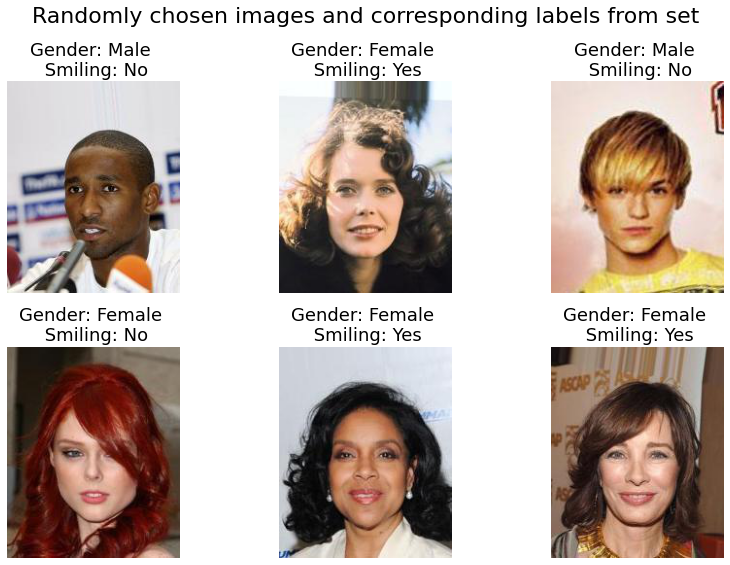

In [3]:
"""
L O A D   D A T A 
"""
# Define a path to the data - REMEMBER TO RESET THIS BEFORE TURNING IN
img_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/img/"
label_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/"

# Load image and label data with the novel 'import_data' module
X , y , random_img = ds.dataImport(img_path,label_path,surpress=False,return_img_indices=True)

### Split Data
We'll then split the data into training-, validation- and test folds.

Plotting the dataset split...


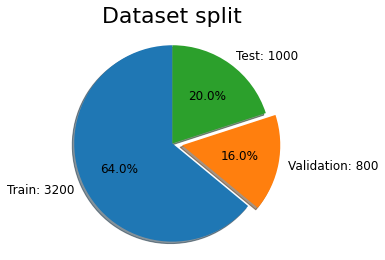

In [4]:
"""
S P L I T   D A T A
"""
    
# Split dataset into train-, validation- and test folds
Xtrain,Xval,Xtest,ytrain,yval,ytest = sd.split_dataset(X,y,test_size=0.2,val_size=0.2,surpress=False)

### Pre-Process Data
Prior to training our classifiers on the data, we perform pre-processing.
This involves some image processing, in the form of merging the RGB channels to a single Grayscale plane, centering the image data on the mean, and then performing principal component analysis with Singular Value Decomposition.

In [40]:
from skimage.feature import hog
from skimage import data, exposure

In [41]:
XtrainHOGdescriptor = []
XtrainHOGimg = []
XvalHOGdescriptor = []
XvalHOGimg = []
XtestHOGdescriptor = []
XtestHOGimg = []

### Generate HOG desriptor for: Training data

In [42]:
for i in range(len(Xtrain)):
    descriptor,image = hog(Xtrain[i], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    XtrainHOGdescriptor.append(descriptor)
    XtrainHOGimg.append(image)
    
XtrainHOGdescriptor = np.array(XtrainHOGdescriptor)

### Generate HOG desriptor for: Validation data

In [43]:
for i in range(len(Xval)):
    descriptor,image = hog(Xval[i], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    XvalHOGdescriptor.append(descriptor)
    XvalHOGimg.append(image)
    
XvalHOGdescriptor = np.array(XvalHOGdescriptor)

### Generate HOG desriptor for: Test data

In [44]:
for i in range(len(Xtest)):
    descriptor,image = hog(Xtest[i], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    XtestHOGdescriptor.append(descriptor)
    XtestHOGimg.append(image)
    
XtestHOGdescriptor = np.array(XtestHOGdescriptor)

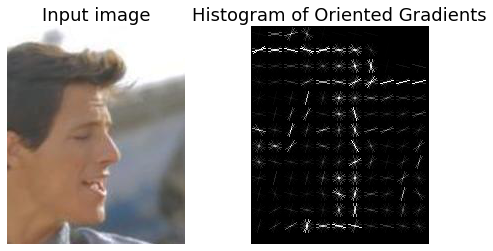

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(Xtest[0], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(XtestHOGimg[0], in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### Prepare Labels

In [48]:
# The labels are -1 = Female, 1 = Male
# Here, I'm transferring them to the space I € [0...1]
ytrain_A1 = ytrain['gender'].values[:]
ytrain_A1[ytrain_A1<0] = 0
yval_A1 = yval['gender'].values[:]
yval_A1[yval_A1<0] = 0
ytest_A1 = ytest['gender'].values[:]
ytest_A1[ytest_A1<0]=0

# The labels are -1 = Female, 1 = Male
# Here, I'm transferring them to the space I € [0...1]
ytrain_A2 = ytrain['smiling'].values[:]
ytrain_A2[ytrain_A2<0] = 0
yval_A2 = yval['smiling'].values[:]
yval_A2[yval_A2<0] = 0
ytest_A2 = ytest['smiling'].values[:]
ytest_A2[ytest_A2<0]=0

# Classifier: Logistic Regression

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [64]:
# sklearn functions implementation
def logRegrPredict(Xtrain,ytrain,Xtest, solver='lbfgs'):
    # Build Logistic Regression Model
    logreg = LogisticRegression(solver=solver) # lbfgs solver used for small datasets, 
    # Train the model using the training sets
    logreg.fit(Xtrain, ytrain)
    ypred= logreg.predict(Xtest)
    #print('Accuracy on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
    return ypred

### Incrementally predict with different number of principal components and store accuracy scores

In [66]:
"""
P E R F O R M   L O G I S T I C   R E G R E S S I O N
"""
solvers2try = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']   
A1_LR_Accuracy = []
A2_LR_Accuracy = []

for solver in solvers2try:
    # A1 - Accuracy
    ypred_A1 = logRegrPredict(XtrainHOGdescriptor, ytrain_A1, XtestHOGdescriptor,solver=solver)
    A1_LR_Accuracy.append(accuracy_score(ytest_A1,ypred_A1))

    # A2 - Accuracy
    ypred_A2 = logRegrPredict(XtrainHOGdescriptor, ytrain_A2, XtestHOGdescriptor,solver=solver)
    A2_LR_Accuracy.append(accuracy_score(ytest_A2,ypred_A2))

A1_LR_Accuracy = np.array(A1_LR_Accuracy)    
A2_LR_Accuracy = np.array(A2_LR_Accuracy)

/opt/anaconda3/envs/MLS-I/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/MLS-I/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

### Report results, i.e. which solver yields best results

In [119]:
pd.DataFrame((A1_LR_Accuracy*100,A2_LR_Accuracy*100),columns=solvers2try, index = ['Task A1','Task A2'])

liblinear  newton-cg  lbfgs   sag  saga
Task A1       87.3       87.3   87.3  87.4  87.6
Task A2       83.4       83.6   83.1  83.4  83.4

# Classifier: kNN

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def KNNClassifier(Xtrain, ytrain, Xtest,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(Xtrain, ytrain) # Fit KNN model


    ypred = neigh.predict(Xtest)
    return ypred

## Task A1 & A2

In [126]:
k_range = np.arange(1,50+1,1)
A1_kNN_Accuracy = []
A2_kNN_Accuracy = []

for k in k_range:
    ypred=KNNClassifier(XtrainHOGdescriptor, ytrain_A1, XtestHOGdescriptor,k)
    A1_kNN_Accuracy.append(metrics.accuracy_score(ytest_A1,ypred))
    
    ypred=KNNClassifier(XtrainHOGdescriptor, ytrain_A2, XtestHOGdescriptor,k)
    A2_kNN_Accuracy.append(metrics.accuracy_score(ytest_A2,ypred))
    
A1_kNN_Accuracy = np.array(A1_kNN_Accuracy)
A2_kNN_Accuracy = np.array(A2_kNN_Accuracy)

## Report results

In [148]:
fig,ax = plt.subplots(2, figsize = (16,10))

ax[0].plot(k_range,A1_kNN_Accuracy,marker='o')

xyMax = {'x': k_range[np.argmax(A1_kNN_Accuracy)], 
         'y': A1_kNN_Accuracy.max()
        }

ax[0].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[0].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x']+4.5,xyMax['y']-0.005))
ax[0].grid("on")
ax[0].set_title("Task A1 - Gender Detection")

ax[1].plot(k_range,A2_kNN_Accuracy,marker='o')

xyMax = {'x': k_range[np.argmax(A2_kNN_Accuracy)], 
         'y': A2_kNN_Accuracy.max()
        }

ax[1].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[1].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x']-4,xyMax['y']-0.025))
ax[1].grid("on")
ax[1].set_title("Task A2 - Smile Detection")

plt.suptitle("HOG with k-Nearest Neighbours")
plt.tight_layout()
fig.set_dpi(800)
plt.show()

# Classifier: SVM

In [158]:
from sklearn import svm

In [159]:
clf = svm.SVC()

In [ ]:
A1_SVM_accuracy = 0.
A2_SVM_accuracy = 0.

# Training the decision tree classifier on training set. 
clf.fit(XtrainHOGdescriptor,ytrain_A1)

# Predicting labels on the test set.
ypred_A1 = clf.predict(XtestHOGdescriptor)
A1_SVM_accuracy = (accuracy_score(ytest_A1,ypred_A1))
print('Task A1 - Accuracy score on the test data: {:.1f}%'.format(A1_SVM_accuracy*100))

# Training the decision tree classifier on training set. 
clf.fit(XtrainHOGdescriptor,ytrain_A2)

# Predicting labels on the test set.
ypred_A2 = clf.predict(XtestHOGdescriptor)
A2_SVM_accuracy = (accuracy_score(ytest_A2,ypred_A2))

print('Task A2 - Accuracy score on the test data: {:.1f}%'.format(A2_SVM_accuracy*100))

**There was some mixup here - As I wasn't initialising the A1_SVM vector in the cell above, and stopped execution
because of a bug initially, I have 21 accuracy scores instead of 20... this cell takes a loooong time to compute so
I won't be fixing it for now, I'll just slice the first number off with [1:21]**

In [383]:
A1_SVM_accuracy[1:21]

array([0.546, 0.674, 0.699, 0.715, 0.739, 0.721, 0.778, 0.797, 0.791,
       0.798, 0.807, 0.843, 0.81 , 0.743, 0.726, 0.757, 0.734, 0.731,
       0.721, 0.708])

In [387]:
fig,ax = plt.subplots(2, figsize = (16,10))

ax[0].plot(test_range,A1_SVM_accuracy[1:21],marker='o')

xyMax = {'x': test_range[np.argmax(A1_SVM_accuracy)-1], 
         'y': A1_SVM_accuracy.max()
        }

ax[0].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[0].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x']-50,xyMax['y']-0.05))
ax[0].grid("on")
ax[0].set_title("Task A1 - Gender Detection")

ax[1].plot(test_range,A2_SVM_accuracy[1:21],marker='o')

xyMax = {'x': test_range[np.argmax(A2_SVM_accuracy)-1], 
         'y': A2_SVM_accuracy.max()
        }

ax[1].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[1].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x'],xyMax['y']-0.05))
ax[1].grid("on")
ax[1].set_title("Task A2 - Smile Detection")

plt.suptitle("PCA with Support Vector Machine")
plt.tight_layout()
fig.set_dpi(800)
plt.show()

### Conclusion
With PCA and SVM a fine classifier may be realised, with 200 components for Task A1, and 70 components for Task A2, yielding accuracies $>80\%$<br>
We've still got an ace up our sleeve, and that is, that we may tune the hyperparameters of the SVM to achieve optimal performance. Our baseline for task A1 will be, an SVM that takes in 200 features, and for task A2, will be an SVM which input is 70 features.

## Task A1

In [397]:
clf = svm.SVC()

In [398]:
"""
F I T   V A L I D A T I O N   A N D   T E S T   T O   P C A 
"""
principalComponents = 200

# Principal components to retain
XtrainPC = prp.fitPCA(WT,Xtrain,n_components=principalComponents)
XvalPC = prp.fitPCA(WT,Xval,n_components=principalComponents)
XtestPC = prp.fitPCA(WT,Xtest,n_components=principalComponents)

# Scale
XtrainScl = scaler.fit_transform(XtrainPC)
XvalScl = scaler.fit_transform(XvalPC)
XtestScl = scaler.fit_transform(XtestPC)

Fitting to PCA base
Fitting to PCA base
Fitting to PCA base


In [399]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['linear']
             }  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(XtrainScl, ytrain_A1) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.859, total=   1.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.875, total=   1.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.902, total=   1.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.878, total=   1.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.852, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.859, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.875, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.902, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.878, total=   1.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[CV] ....... C=100, gamma=1, kernel=linear, score=0.859, total=   7.0s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.880, total=   7.7s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.894, total=   7.5s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.870, total=   5.3s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.845, total=   6.0s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.859, total=   7.0s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.880, total=   7.8s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.2min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear']},
             verbose=3)

In [400]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1, gamma=1, kernel='linear')


In [401]:
tuned_HP = grid.best_params_

In [402]:
tuned_SVM = svm.SVC(**tuned_HP)

In [414]:
tuned_SVM.fit(XtrainScl, ytrain_A1)

SVC(C=1, gamma=1, kernel='linear')

In [415]:
ypred = tuned_SVM.predict(XtestScl)

In [416]:
print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_A1, y_pred=tuned_SVM.predict(XtrainScl)))
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A1, y_pred=ypred))

Accuracy Score on train data:  0.905
Accuracy Score on the test data:  0.87


In [417]:
# print prediction results 
print(metrics.classification_report(ytest_A1, ypred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       511
           1       0.86      0.88      0.87       489

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



## Task A2

In [419]:
clf = svm.SVC()

In [420]:
"""
F I T   V A L I D A T I O N   A N D   T E S T   T O   P C A 
"""
principalComponents = 70

# Principal components to retain
XtrainPC = prp.fitPCA(WT,Xtrain,n_components=principalComponents)
XvalPC = prp.fitPCA(WT,Xval,n_components=principalComponents)
XtestPC = prp.fitPCA(WT,Xtest,n_components=principalComponents)

# Scale
XtrainScl = scaler.fit_transform(XtrainPC)
XvalScl = scaler.fit_transform(XvalPC)
XtestScl = scaler.fit_transform(XtestPC)

Fitting to PCA base
Fitting to PCA base
Fitting to PCA base


In [421]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100,1000],  
              'gamma': [1, 0.1, 0.01, 0.001,0.0001], 
              'kernel': ['linear']
             }  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(XtrainScl, ytrain_A2) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.820, total=   0.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.802, total=   0.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.808, total=   0.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.792, total=   0.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.816, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.820, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.802, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.808, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.792, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.844, total=   0.3s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.805, total=   0.4s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.798, total=   0.4s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.803, total=   0.3s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.820, total=   0.4s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.844, total=   0.4s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.805, total=   0.3s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .

[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.808, total=  10.0s
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.823, total=  10.1s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.844, total=  13.0s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.808, total=   9.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.795, total=  10.7s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.808, total=   9.9s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.823, total=  10.3s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  5.4min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             verbose=3)

In [422]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1000, gamma=1, kernel='linear')


In [423]:
tuned_HP = grid.best_params_

In [424]:
tuned_SVM = svm.SVC(**tuned_HP)

In [425]:
tuned_SVM.fit(XtrainScl, ytrain_A2)

SVC(C=1000, gamma=1, kernel='linear')

In [426]:
ypred = tuned_SVM.predict(XtestScl)

In [427]:
print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_A2, y_pred=tuned_SVM.predict(XtrainScl)))
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A2, y_pred=ypred))

Accuracy Score on train data:  0.8228125
Accuracy Score on the test data:  0.836


In [428]:
# print prediction results 
print(metrics.classification_report(ytest_A2, ypred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       489
           1       0.84      0.84      0.84       511

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



### Conclusion
SVMs may be used to obtain 80-90% accuracy on the data with PCA

# Classifier: CNN

In [514]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.optimizers import RMSprop

In [515]:
batch_size = 128
num_classes = 2
epochs = 100

In [516]:
"""
U S E   T H E   W H O L E   G R A Y S C A L E   I M A G E S 
"""

# Principal components to retain
XtrainPC = Xtrain
XvalPC = Xval
XtestPC = Xtest

# Scale
XtrainScl = scaler.fit_transform(XtrainPC)
XvalScl = scaler.fit_transform(XvalPC)
XtestScl = scaler.fit_transform(XtestPC)

In [517]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(38804,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [518]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1024)              39736320  
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_38 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_39 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 514       
Total params: 41,442,562
Trainable params: 41,442,562
Non-trainable params: 0
_________________________________________________________________


In [519]:
# Transform labels for CNN categorical_crossentropy
from keras.utils import to_categorical

ytrain_bin_A1 = to_categorical(ytrain_A1)
yval_bin_A1 = to_categorical(yval_A1)
ytest_bin_A1 = to_categorical(ytest_A1)

In [520]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


history = model.fit(XtrainScl, ytrain_bin_A1,batch_size=batch_size,epochs=epochs,verbose=1,
                    validation_data=(XvalScl, yval_bin_A1))

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 10s 3ms/step - loss: 32.2500 - accuracy: 0.5075 - val_loss: 1.0932 - val_accuracy: 0.5000
Epoch 2/100
3200/3200 [==============================] - 10s 3ms/step - loss: 1.0838 - accuracy: 0.5166 - val_loss: 0.7650 - val_accuracy: 0.5000
Epoch 3/100
1920/3200 [=================>............] - ETA: 4s - loss: 0.7518 - accuracy: 0.4953

KeyboardInterrupt: 

In [ ]:
ypred = model.predict_classes(XtestScl)

In [ ]:
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A1, y_pred=ypred))